# Graph Vizualizations for the traveling TSP salesman problem

Import modules

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
%matplotlib inline
from src.tsp_instance import TSP
from src.initialization import Initialization
from src.parent_selection import Parent_Selection
from src.recombination import Recombination
from src.mutation import Mutation
from src.evaluation import Evaluation
from src.survivor_selection import Survivor_Selection
from src.termination import Termination
from src.animation import Animation
from src.utils import *
from src.utils import debug_print as print
from src.file_utils import parse_file as parse
from src.preprocessing import precalculate_distances

IMGDIR = "./images/"

x_large_data  = "./data/TSP_Italy_16862.txt"
big_data      = "./data/TSP_Canada_4663.txt"
middle_data   = "./data/TSP_Uruguay_734.txt"
small_data    = "./data/TSP_WesternSahara_29.txt"

Set a comfortable default

In [2]:
POP_SIZE          = 200
MATING_POOL_SIZE = 100
NUM_GENERATIONS   = 10000
TIME_LIMIT        = 10000
MUTATION_RATE     = .2
INIT_METHOD = "random_permutations"
SELECT_METHOD = "roulette_wheel"
CROSSOVER_METHOD = "order_crossover"
MUTATION_METHOD = "flip"
EVALUATION_METHOD = "cached_euclidean"
SURVIVOR_METHOD = "mu_plus_lambda"
TERMINATOR_METHOD = "num_iterations"
DATA              = parse(middle_data)
def reset_params():
    global POP_SIZE
    global MATING_POOL_SIZE
    global NUM_GENERATIONS
    global TIME_LIMIT
    global MUTATION_RATE
    global CROSSOVER_METHOD
    global MUTATION_METHOD
    POP_SIZE          = 200
    MATING_POOL_SIZE = 100
    NUM_GENERATIONS   = 10000
    TIME_LIMIT        = 10000
    MUTATION_RATE     = .2
    CROSSOVER_METHOD = "order_crossover"
    MUTATION_METHOD = "flip"

This is essentially a copy of the main method from traveling_salesman.py, however it returns an instance so several can be compared.

In [3]:
def test_tsp():
    # create all modules and problem instance
    tsp = TSP(
        graph           = DATA,
        population_size = POP_SIZE,
        mating_pool_size= MATING_POOL_SIZE,
        mutation_rate   = MUTATION_RATE,
        num_generations = NUM_GENERATIONS)
    initializer         = Initialization(tsp, INIT_METHOD)
    parent_selector     = Parent_Selection(tsp, SELECT_METHOD)
    mutator             = Mutation(tsp, MUTATION_METHOD)
    evaluator           = Evaluation(tsp, EVALUATION_METHOD)
    recombinator        = Recombination(tsp, CROSSOVER_METHOD, evaluator)
    survivor_selector   = Survivor_Selection(tsp, SURVIVOR_METHOD)
    terminator          = Termination(NUM_GENERATIONS, TIME_LIMIT, TERMINATOR_METHOD)
    # initialize population and perform initial evaluation
    clear_times()
    start_timer("setup")
    initializer.initialize()
    evaluator.evaluate()
    start_timer("setup")
    current_time = 0
    while terminator.method(tsp.current_generation, current_time):
    # select parents and spawn children
        parent_selector.select()
        recombinator.recombine()
        # mutate population and children
        mutator.mutate_population()
        mutator.mutate_children()
        # re-evaluate children and population
        evaluator.evaluate(use_mask=True)
        evaluator.evaluate_children()
        # select from parents and children to form new population
        survivor_selector.select()
        # add history and print debugs every 10%
        tsp.add_history("mean_fitness",tsp.fitness.mean())
        tsp.add_history("best_fitness",tsp.fitness.max())
        std = tsp.fitness.std()
        tsp.add_history("std_dev",std)
        tsp.current_generation +=1
        if not (tsp.current_generation % (tsp.num_generations // 200)):
            tsp.add_history("best_individual", tsp.population[np.argmax(tsp.fitness.max())])
            tsp.add_history("ani_fitness", tsp.fitness.max())
            tsp.add_history("ani_generation", tsp.current_generation)
            
    # print("Best Member of Population:\n", tsp.population[np.argmax(tsp.fitness)])
    tsp.history["times"] = {}
    for k,v in get_times():
        tsp.history["times"][k] = v
#     tsp.add_history("times",get_times())
    print("adding times:",tsp.history["times"])
    return tsp

This method takes in a list of several TSP instances and plots them for comparison. It saves the files in ./images/ so they can be used in other mediums.

In [4]:
def plot_tsps(tsps, scale=1, title=None, file_name=None):
    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Mean Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["mean_fitness"], label=name)
    plt.legend()
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + "-meanFit.png", bbox_inches='tight')
    plt.show()        

    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Best Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["best_fitness"], label = name)
    plt.legend()
    plt.savefig(IMGDIR + file_name + "-bestFit.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Fitness Standard Deviation", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["std_dev"], label = name)
        plt.legend()
    plt.legend()
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + "-std.png", bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Computation Time", size=20*scale)
    times = []
    for name, tsp in tsps.items():
        time = 0
        for k,v in tsp.history['times'].items():
            time+=v
        times.append(time)
    plt.bar(range(len(times)), times, align='center')
    plt.xticks(range(len(times)), tsps.keys())
    plt.tick_params(axis='x', which='major', labelsize=15)
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + "-time.png", bbox_inches='tight')
    plt.show()

List of string names of different methods

In [5]:
crossover_methods = ["order_crossover", "pmx", "scx"]
mutation_methods = ["swap","flip","scramble"]

## Compare Methods
Select a number of runs over which we average our values

In [6]:
NUM_RUNS = 10
vals_to_mean = ["best_fitness","mean_fitness","std_dev"]

## Mutations

Create a TSP instance that represents the mean of several instances. To plot only a single instance the NUM_RUNS variable can simply be set to 1.

In [7]:
reset_params()
mutation_results = {}
set_debug(False) # stop the methods from printing out
for method in mutation_methods:
    MUTATION_METHOD = method #change method
    mean_result = test_tsp()
    other_results = []
    for n in range(NUM_RUNS-1):
        other_results.append(test_tsp())
    # get mean of selected lists
    for name in vals_to_mean:
        hist_to_mean = name
        meanval = np.array(mean_result.history[hist_to_mean])
        for n in range(NUM_RUNS-1):
            meanval += np.array(other_results[n].history[hist_to_mean])
        meanval/=NUM_RUNS
        mean_result.history[hist_to_mean] = meanval.tolist()
    #get mean of times
    for n in range(NUM_RUNS-1):
        for name,time in other_results[n].history["times"].items():
            mean_result.history["times"][name] += time
    for name,time in mean_result.history["times"].items():
        mean_result.history["times"][name] /= NUM_RUNS
    mutation_results[method] = mean_result
set_debug(True)

The results of the tests are plotted here as well as saved to the disk.

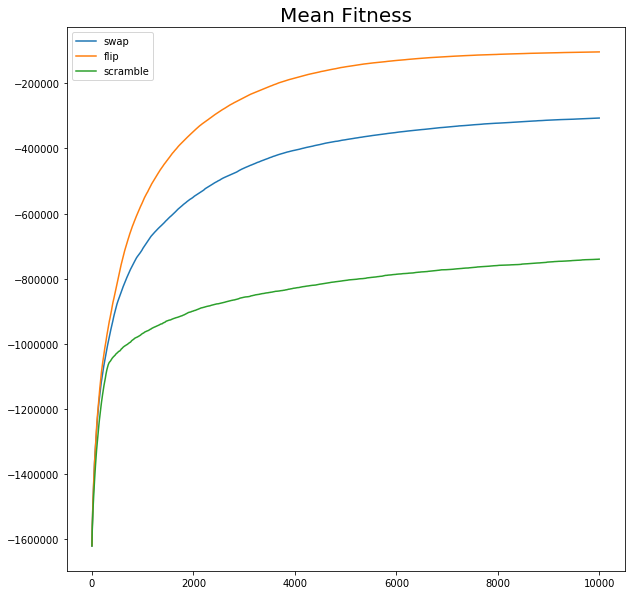

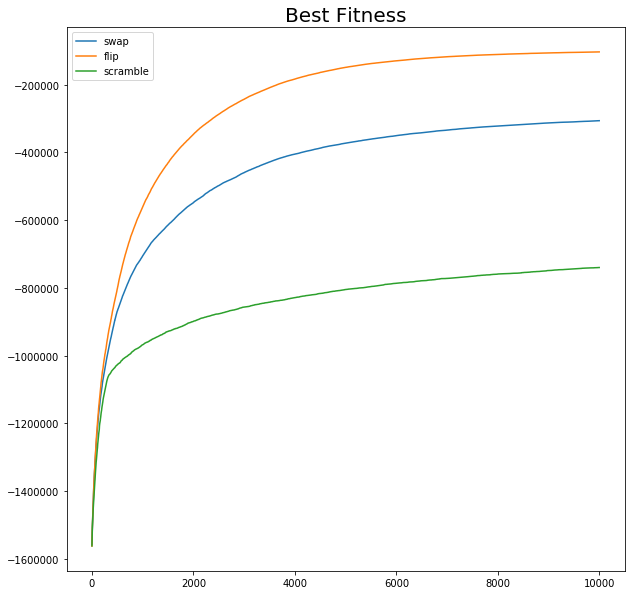

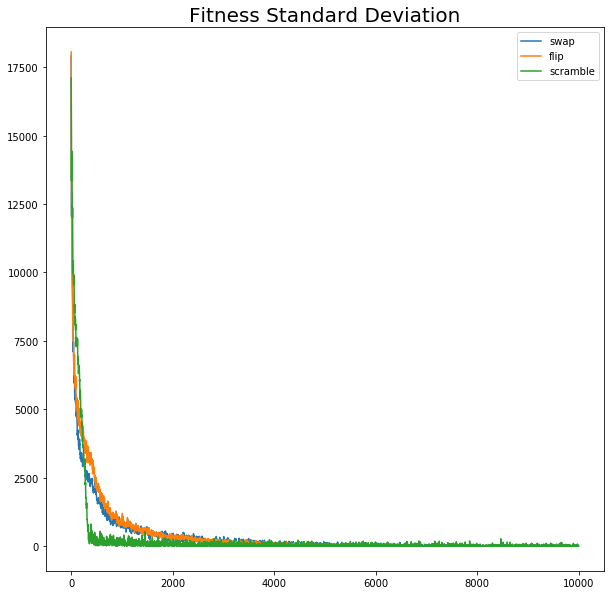

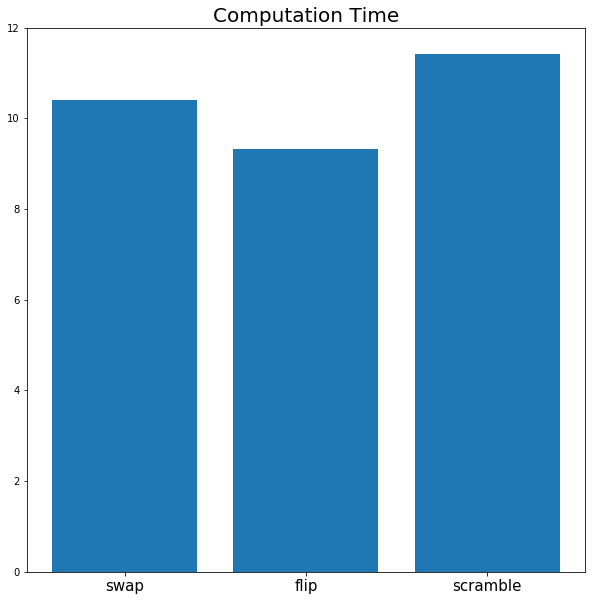

In [8]:
plot_tsps(mutation_results, title="Mutation Methods Compared", file_name="mutation_methods")

## Crossover Method Comparisons

In [9]:
reset_params()
crossover_results = {}
set_debug(False) # stop the methods from printing out
for method in crossover_methods:
    CROSSOVER_METHOD = method
    mean_result = test_tsp()
    other_results = []
    for n in range(NUM_RUNS-1):
        other_results.append(test_tsp())
    # get mean of selected lists
    for name in vals_to_mean:
        hist_to_mean = name
        meanval = np.array(mean_result.history[hist_to_mean])
        for n in range(NUM_RUNS-1):
            meanval += np.array(other_results[n].history[hist_to_mean])
        meanval/=NUM_RUNS
        mean_result.history[hist_to_mean] = meanval.tolist()
    #get mean of times
    for n in range(NUM_RUNS-1):
        for name,time in other_results[n].history["times"].items():
            mean_result.history["times"][name] += time
    for name,time in mean_result.history["times"].items():
        mean_result.history["times"][name] /= NUM_RUNS
    crossover_results[method] = mean_result
set_debug(True)

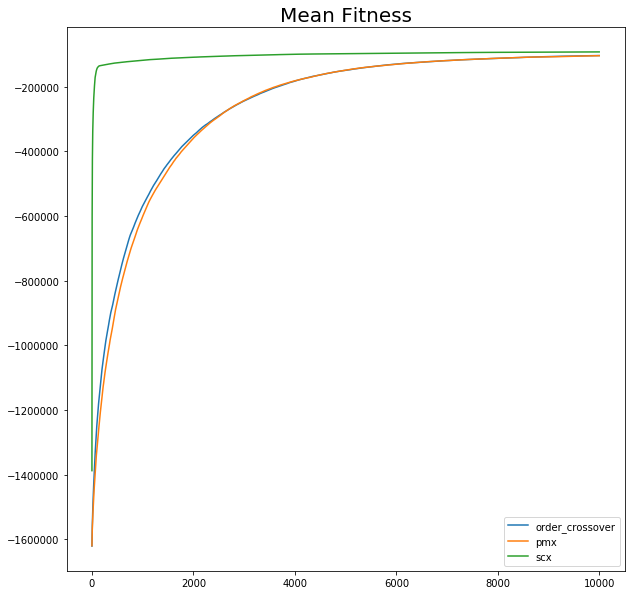

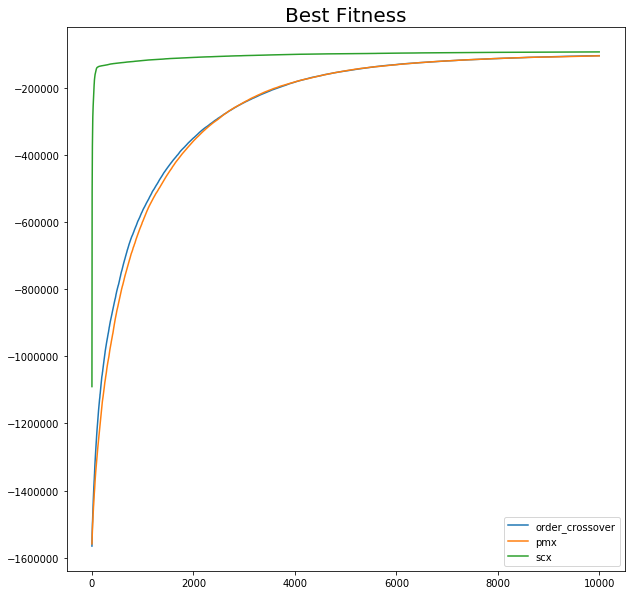

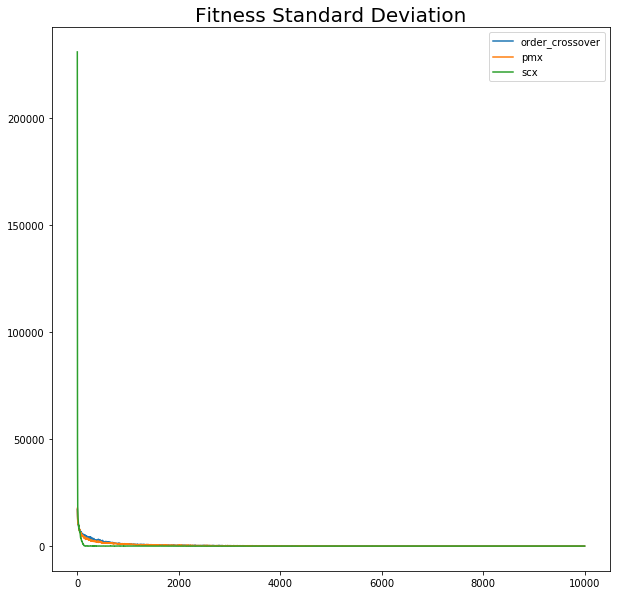

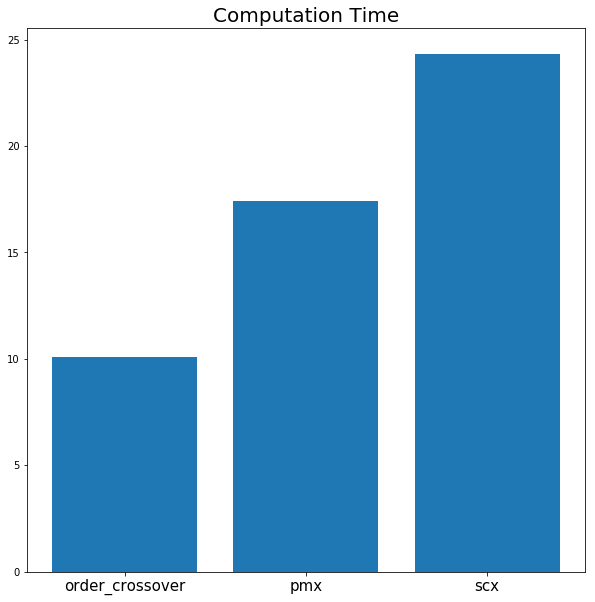

In [10]:
plot_tsps(crossover_results, title="Crossover Methods Compared", file_name="crossover_methods")